# Notebook for running Poisson LDS with inputs
## One-hot encoding for each pattern
## Stim ONLY trials, no behavior
## Shortening the amount of time to fit the model to 5ms before stim to 10ms after stim

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [2]:
mat = loadmat("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt2.mat")
mat = mat['data']

print(mat.dtype.names)

('totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success')


In [3]:
data_struct = mat[0, 0]  # MATLAB structs are 2D arrays even if 1x1
data = {field: data_struct[field] for field in mat.dtype.names}

In [4]:
data.keys()

dict_keys(['totTime', 'cue', 'laser', 'trial_start', 'cue_rec_time', 'cue_trial_time', 'laser_rec_time', 'laser_trial_time', 'field_size', 'pattern_xy', 'field_id', 'full_field', 'pattern_id', 'pattern_fill', 'lift_ms', 'lift', 'grab_ms', 'grab', 'mouth_ms', 'mouth', 'single', 'any', 'no_success'])

# Get stim only trials

In [5]:
stim_idxs = np.where(data["pattern_id"] > 2)[0]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [6]:
np.unique(data["pattern_id"][stim_idxs])

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=uint8)

In [7]:
stim_idxs.shape

(269,)

## Get relevant time information

In [8]:
laser_times = data["laser_rec_time"]
laser_times.shape

(1, 450)

## Get the AP.bin file

In [9]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [10]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [11]:
meta_data = get_meta(meta_path)

In [12]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [13]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [14]:
vmax

0.6

In [15]:
imax

512.0

In [16]:
gain

500.0

# Get trials

In [17]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        start_time = int((laser_times[:, trial_no] - 50) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        end_time = int((laser_times[:, trial_no] + 5 + 50) / 1_000 * 30_000)

    
        trial = ap_data[:150, start_time:end_time]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        c_start = int(laser_times[:, trial_no] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [18]:
bin_size = 1

In [19]:
#model_data = get_trials(stim_idxs, bin_size)

In [20]:
# save as a pickle file 
import pickle

In [21]:
filename = f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/{bin_size}ms_data.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(model_data, file)

In [22]:
with open(filename, "rb") as file:
    model_data = pickle.load(file)

# Take 5 ms before stim to 10ms after stim

In [23]:
model_data = [d[45:66] for d in model_data]

# Design the input matrix

In [24]:
# get the pattern types

In [25]:
p_ids = np.unique(data["pattern_id"][stim_idxs])

p_ids

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=uint8)

In [26]:
p_ids.shape

(27,)

## Get colors for plotting

In [27]:
c = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple",
    "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
    "blue", "orange", "green", "red", "purple", "brown", "pink",
    "gray", "olive", "cyan", "gold", "lime", "navy", "magenta",
    "teal", "coral", "darkgreen"
]

## Create encodings 

In [28]:
encodings = np.eye(p_ids.shape[0])
encodings.shape

(27, 27)

In [29]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][i][0]) - 3

    colors.append(c[p_id])

    encoding = encodings[p_id] 

    # stack the encoding for every timepoint (each bin)
    nput = np.vstack([encoding] * d.shape[0])

    inputs.append(nput)

# Fit the model

In [30]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.LDS(obs_dim, state_dim, M=27, emissions="poisson", emission_kwargs=dict(link="softplus"))

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [31]:
# plot my elbos

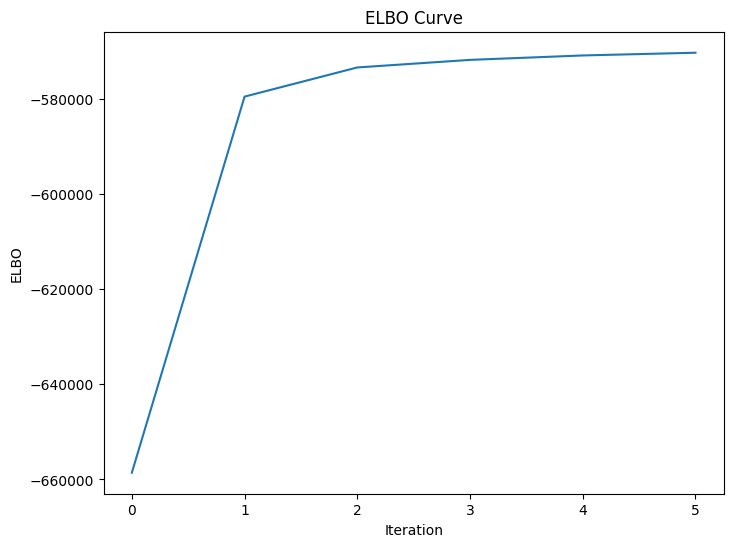

In [32]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [33]:
A_est = plds.dynamics.A
b_est = plds.dynamics.b

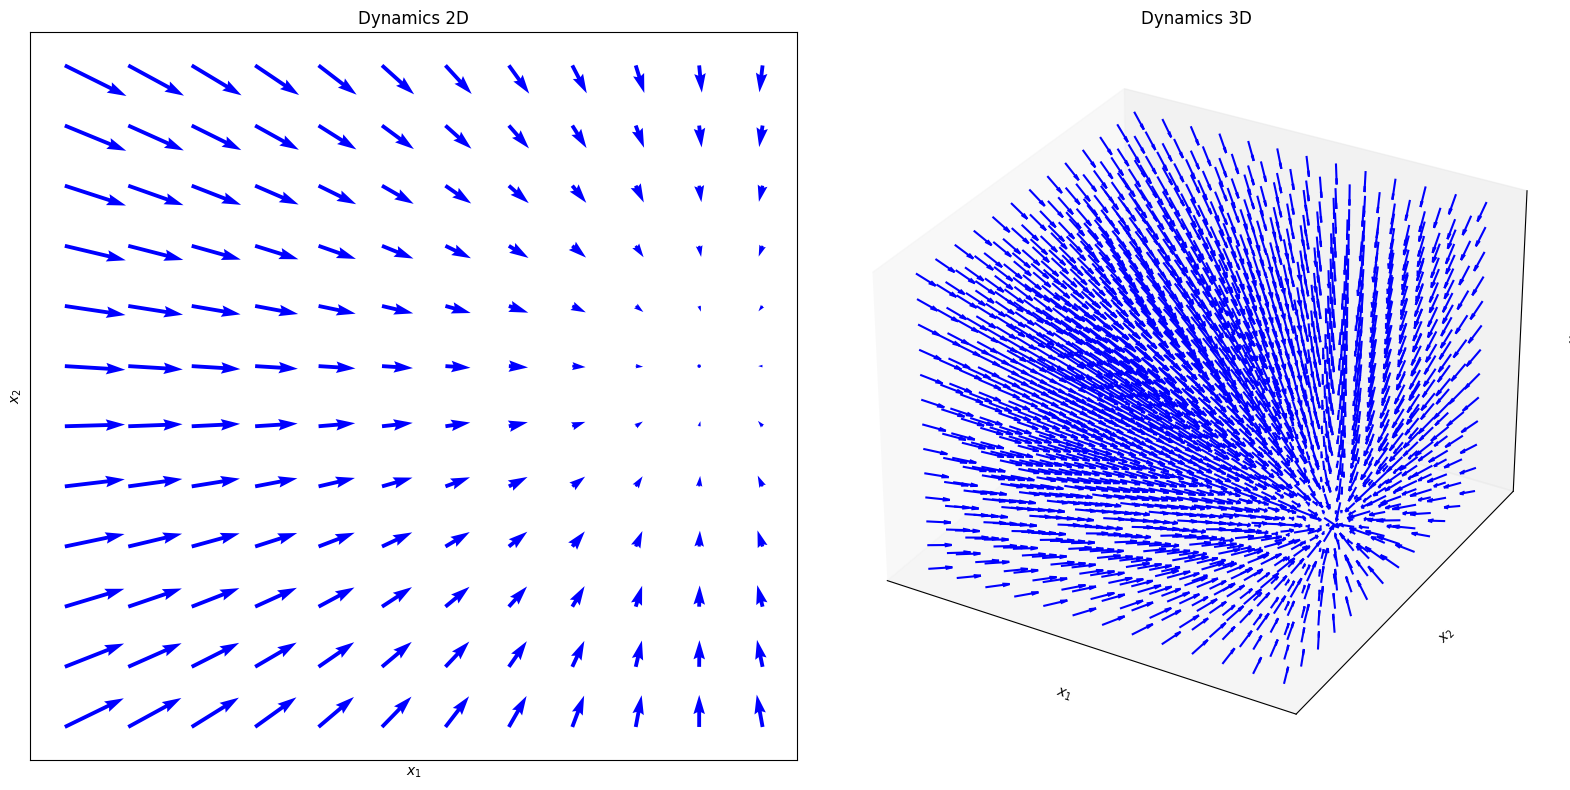

In [34]:
fig = plt.figure(figsize=(16, 8))

# 2D subplot
ax1 = fig.add_subplot(1, 2, 1)
plot_dynamics_2d(A_est[:2, :2], b_est[:2], ax1, npts=12)
ax1.set_title('Dynamics 2D')
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

ax1.set_xticks([])
ax1.set_yticks([])

# 3D subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plot_dynamics_3d(A_est, b_est, ax2, npts=13, colors="blue")

ax2.set_title('Dynamics 3D')

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("$x_3$")

plt.tight_layout()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/dynamics_{bin_size}ms.png")

plt.show()

## Posterior Means 2D (all trials)

In [35]:
from matplotlib.patches import Patch

In [36]:
state_means = q.mean_continuous_states

In [37]:
custom_patches = [Patch(facecolor=c[i-3], edgecolor='black', label=f'{i}') for i in p_ids]

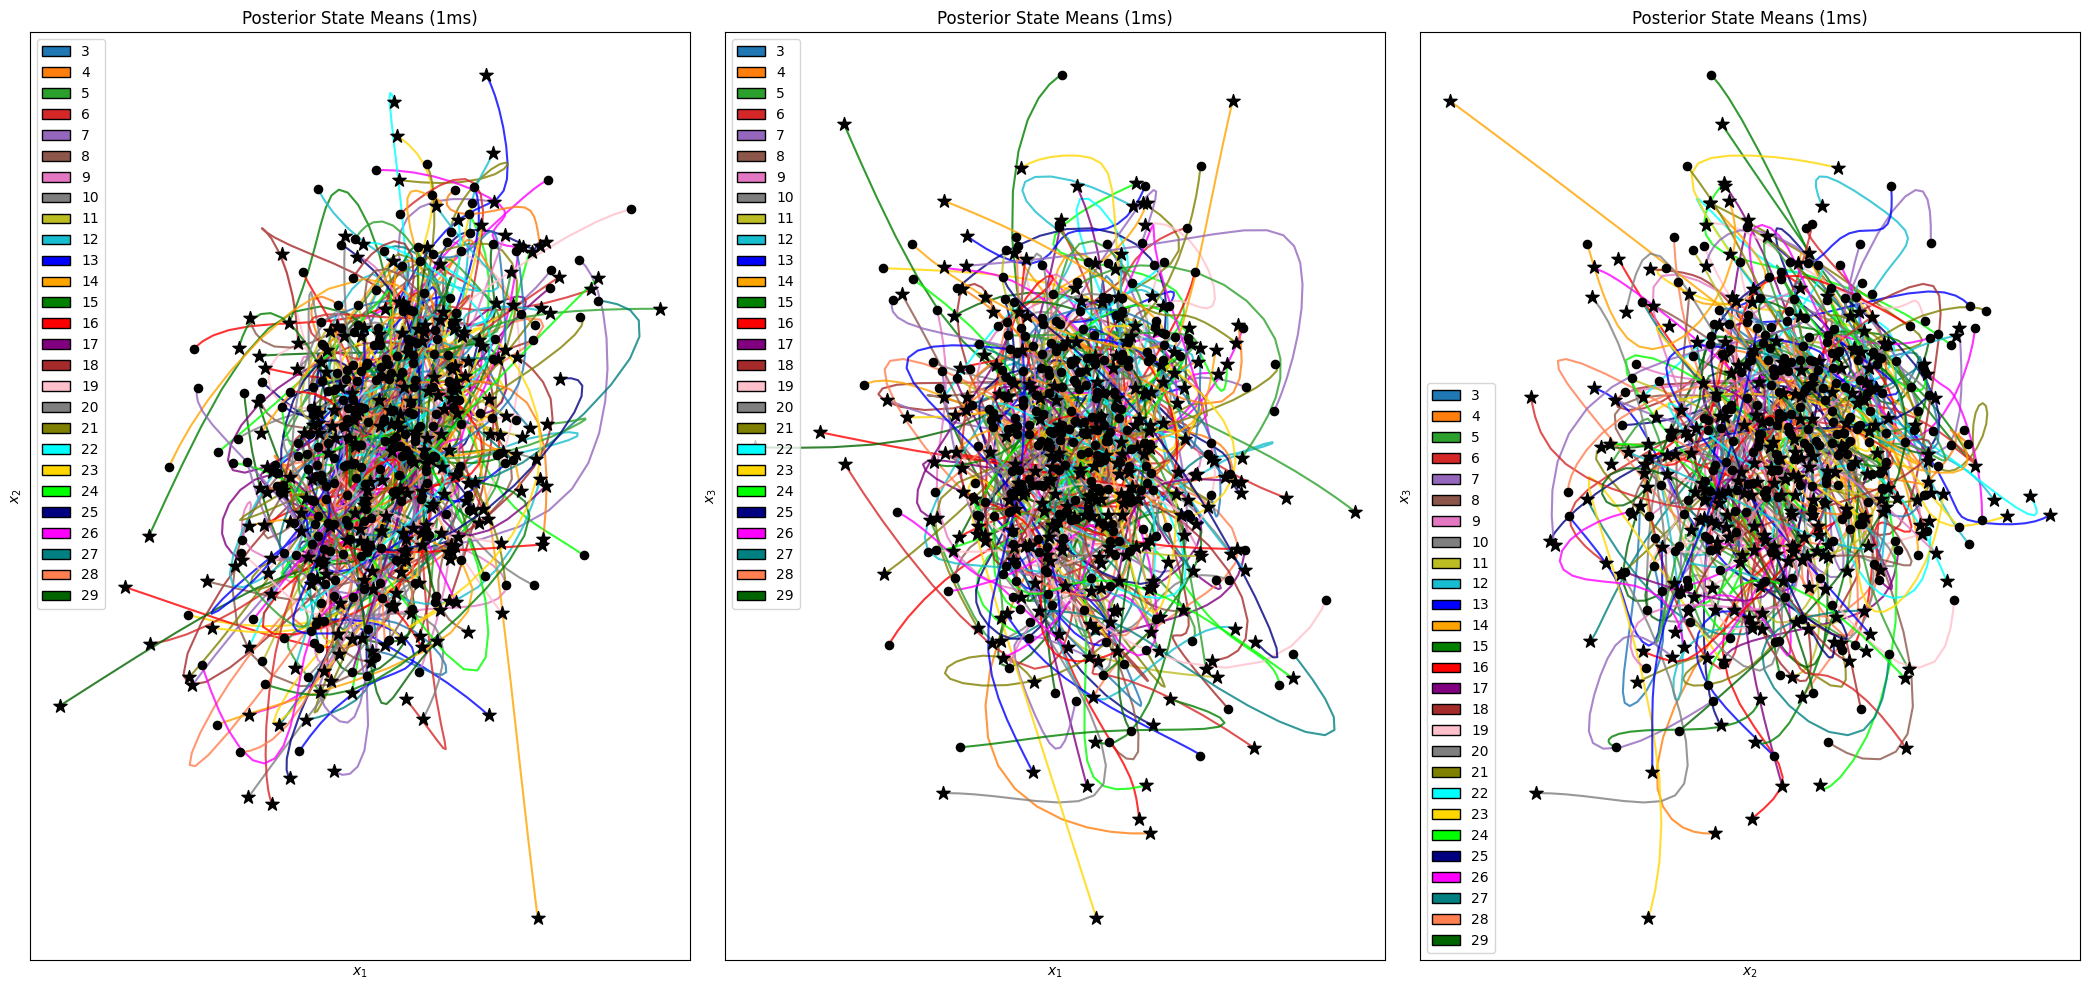

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    p = gaussian_filter1d(p, 4, axis=0)

    axes[0].plot(p[:, 0], p[:, 1], c=colors[i], zorder=0, alpha=0.8)

  #  axes[0].scatter(p[0, 0], p[0, 1], s=35, c="black", zorder=1, alpha=1)
    axes[0].scatter(p[0, 0], p[0, 1], s=35, marker='o', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[-1, 0], p[-1, 1], s=100, marker='*', c="black", zorder=1, alpha=1)

    axes[1].plot(p[:, 0], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[0, 0], p[0, 2], s=35, c="black", zorder=1, alpha=1)

    axes[1].scatter(p[-1, 0], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[:, 1], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[0, 1], p[0, 2], s=35, c="black", zorder=1, alpha=1)
    axes[2].scatter(p[-1, 1], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_3$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel("$x_2$")
axes[2].set_ylabel("$x_3$")

plt.tight_layout()


plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/state_means_{bin_size}ms_2D.png")

## Posterior Means 3D (all trials)

In [39]:
# a single 3d plot of all 

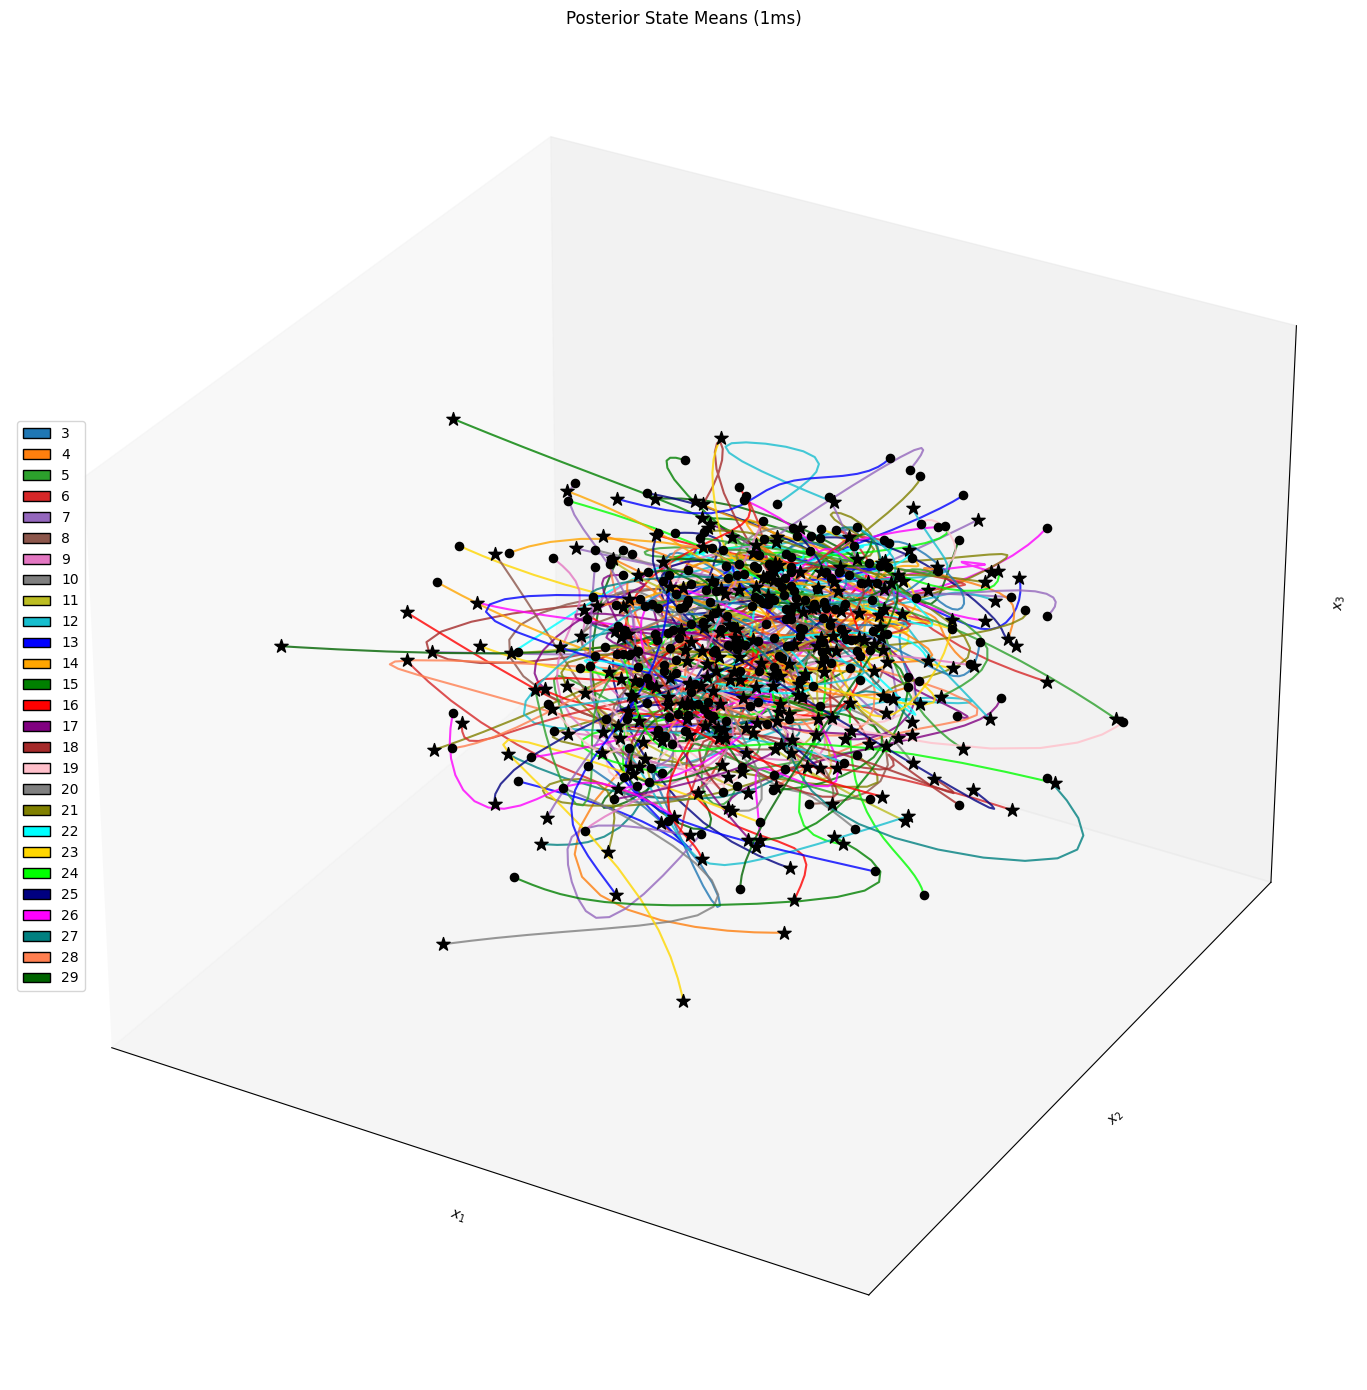

In [40]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, p in enumerate(state_means):

    p = gaussian_filter1d(p, 4, axis=0)

    ax.plot(p[:, 0], p[:, 1], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    ax.scatter(p[0, 0], p[0, 1], p[0, 2], s=35, c="black", zorder=1, alpha=1)
    #ax.scatter(p[grab - lift + lift_start, 0], p[grab-lift +lift_start, 1], p[grab-lift +lift_start, 2], s=10, c="red")
    ax.scatter(p[-1, 0], p[-1, 1], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)

ax.set_title(f"Posterior State Means ({bin_size}ms)")

ax.legend(handles=custom_patches, loc='center left')


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")


plt.tight_layout()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/state_means_{bin_size}ms_3D.png")

# State means of individual patterns 
# stim to 10ms after stim

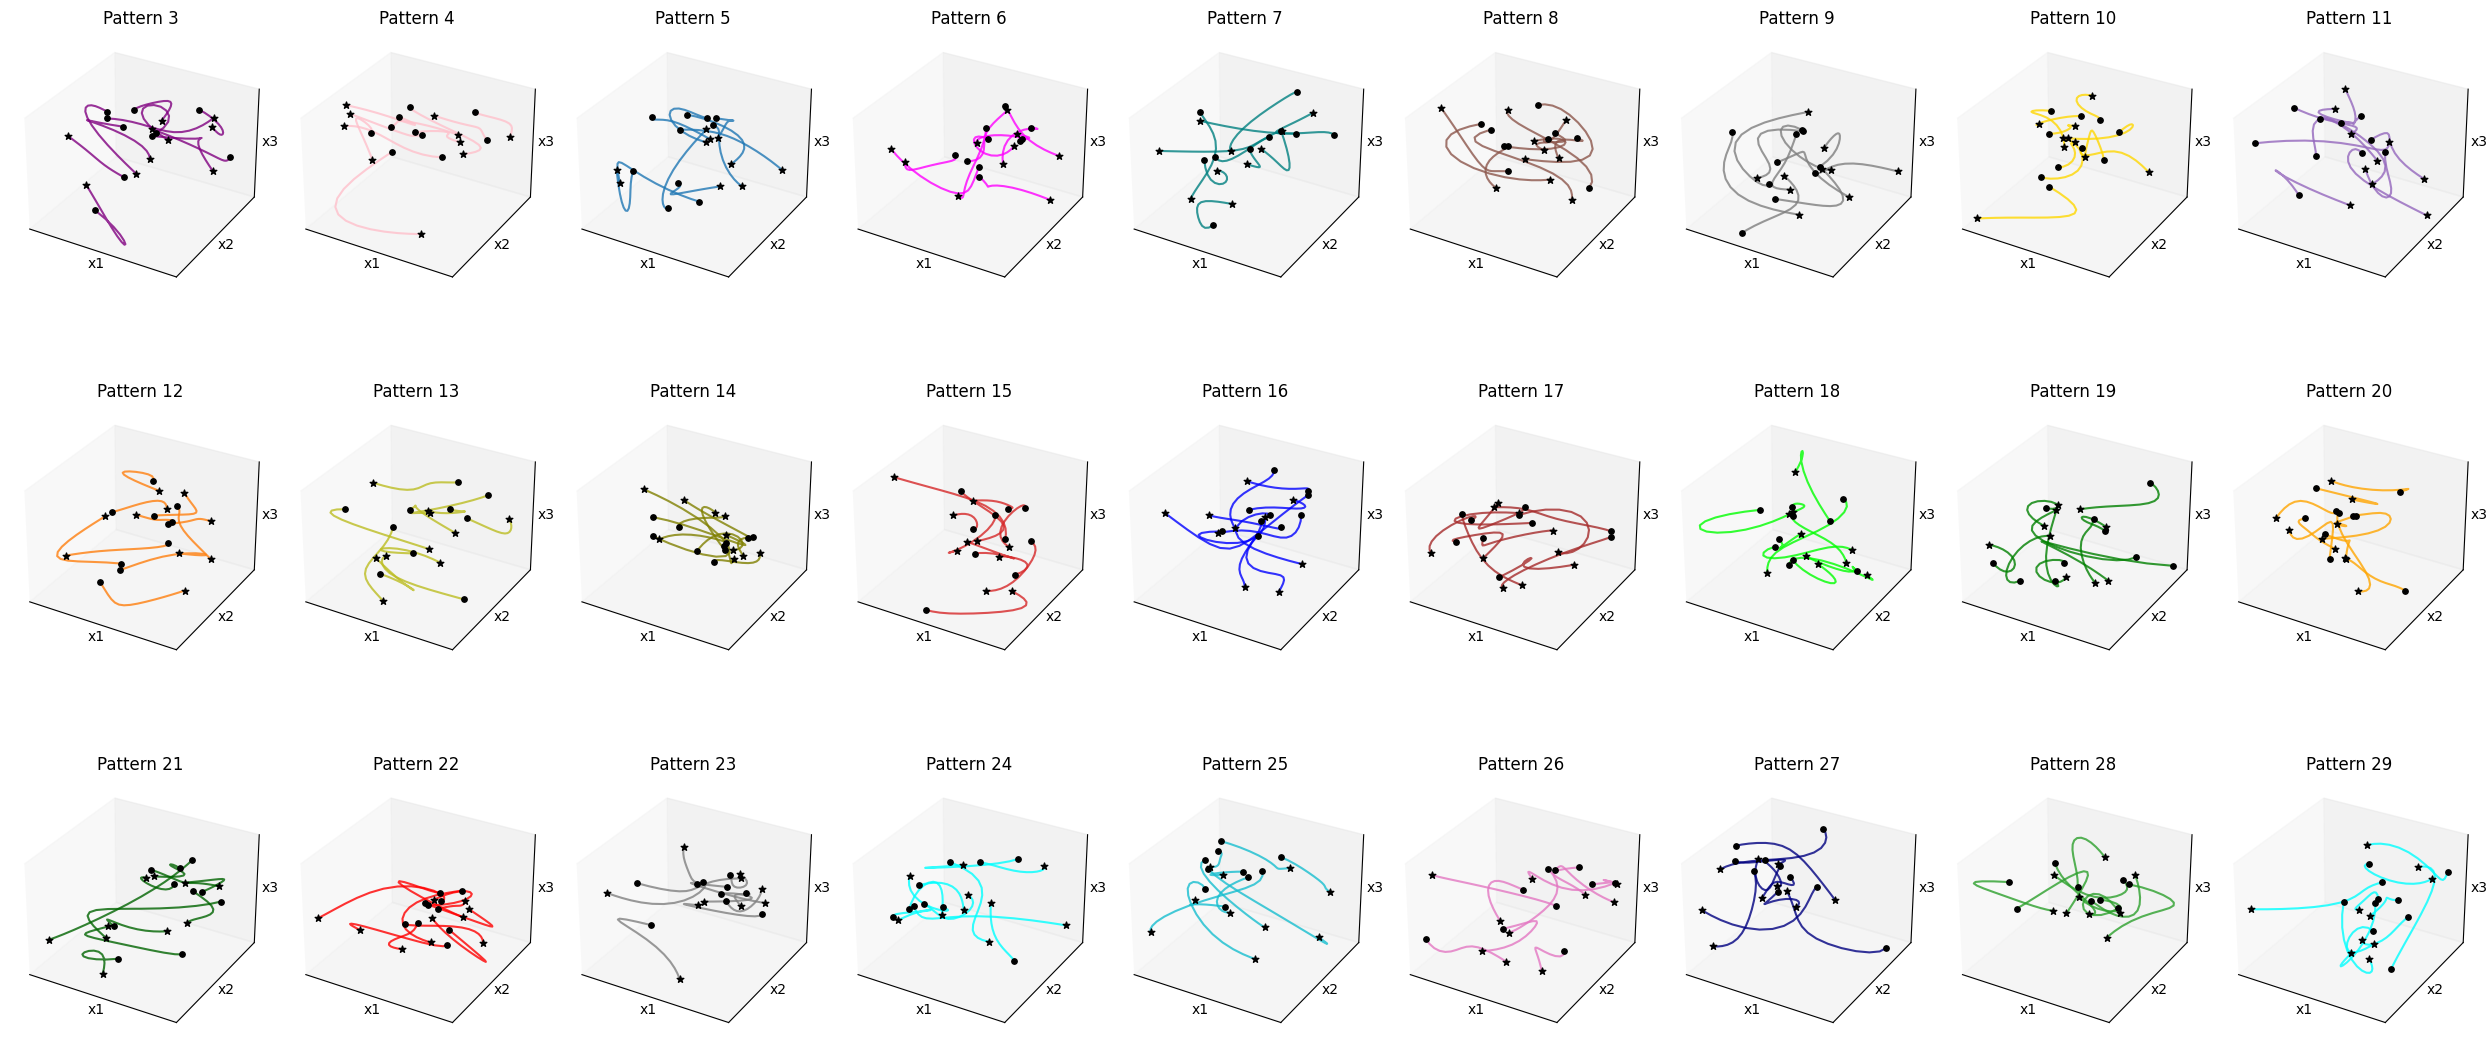

In [45]:
# create a subplot for each pattern
fig, axes = plt.subplots(3, 9, figsize=(25, 12), subplot_kw={"projection": "3d"})

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, j in enumerate(p_ids):
    # get trials where this pattern happens 
    idxs = np.where(data["pattern_id"][stim_idxs] == j)[0]

    for z in idxs:
        p = gaussian_filter1d(state_means[z], 4, axis=0)
        axes[i].plot(p[5:, 0], p[5:, 1], p[5:, 2], c=colors[i], zorder=0, alpha=0.8)
        axes[i].scatter(p[5, 0], p[5, 1], p[5, 2], s=15, c="black", zorder=1, alpha=1)
       # axes[i].scatter(p[10, 0], p[10, 1], p[10, 2], s=5, c="black", marker="s", zorder=1, alpha=1)
        axes[i].scatter(p[-1, 0], p[-1, 1], p[-1, 2], s=25, marker='*', c="black", zorder=1, alpha=1)

        axes[i].set_title(f"Pattern {j}")


for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel("x1", labelpad=-15)
    ax.set_ylabel("x2", labelpad=-15)
    ax.set_zlabel("x3", labelpad=-15)


plt.tight_layout()


plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/state_means_patterns_{bin_size}ms_3D.png")

# Average across patterns

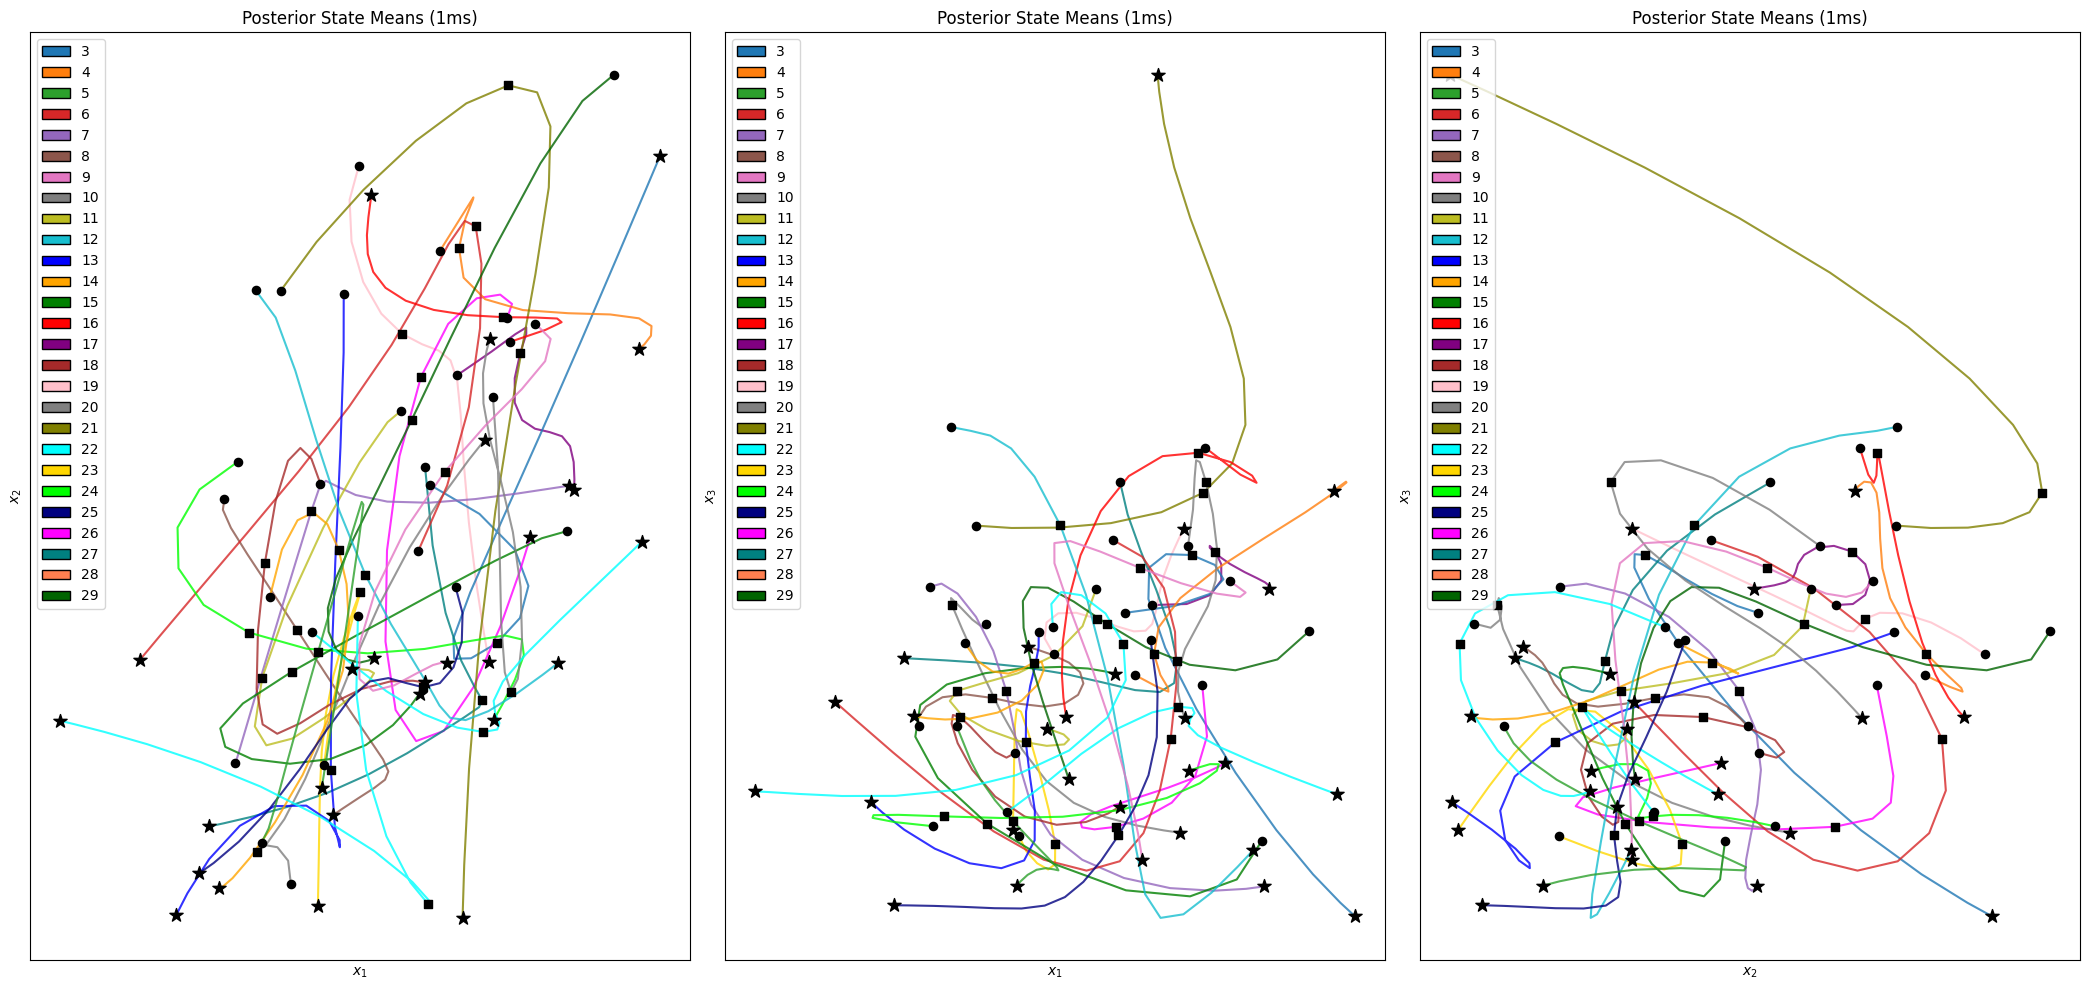

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, j in enumerate(p_ids):
    # get trials where this pattern happens 
    idxs = np.where(data["pattern_id"][stim_idxs] == j)[0]

    d = [state_means[z] for z in idxs]

    d = np.array(d).mean(axis=0)

    p = gaussian_filter1d(d, 3, axis=0)

    axes[0].plot(p[5:, 0], p[5:, 1], c=colors[i], zorder=0, alpha=0.8)

  #  axes[0].scatter(p[0, 0], p[0, 1], s=35, c="black", zorder=1, alpha=1)
    axes[0].scatter(p[5, 0], p[5, 1], s=35, marker='o', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[10, 0], p[10, 1], s=35, marker='s', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[-1, 0], p[-1, 1], s=100, marker='*', c="black", zorder=1, alpha=1)

    axes[1].plot(p[5:, 0], p[5:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[5, 0], p[5, 2], s=35, c="black", zorder=1, alpha=1)
    axes[1].scatter(p[10, 0], p[10, 2], s=35, marker='s', c="black", zorder=1, alpha=1)

    axes[1].scatter(p[-1, 0], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[5:, 1], p[5:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[5, 1], p[5, 2], s=35, c="black", zorder=1, alpha=1)
    axes[2].scatter(p[10, 1], p[10, 2], s=35, marker='s', c="black", zorder=1, alpha=1)
    axes[2].scatter(p[-1, 1], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_3$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel("$x_2$")
axes[2].set_ylabel("$x_3$")

plt.tight_layout()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/state_means_pattern_avg_{bin_size}ms_2D.png")

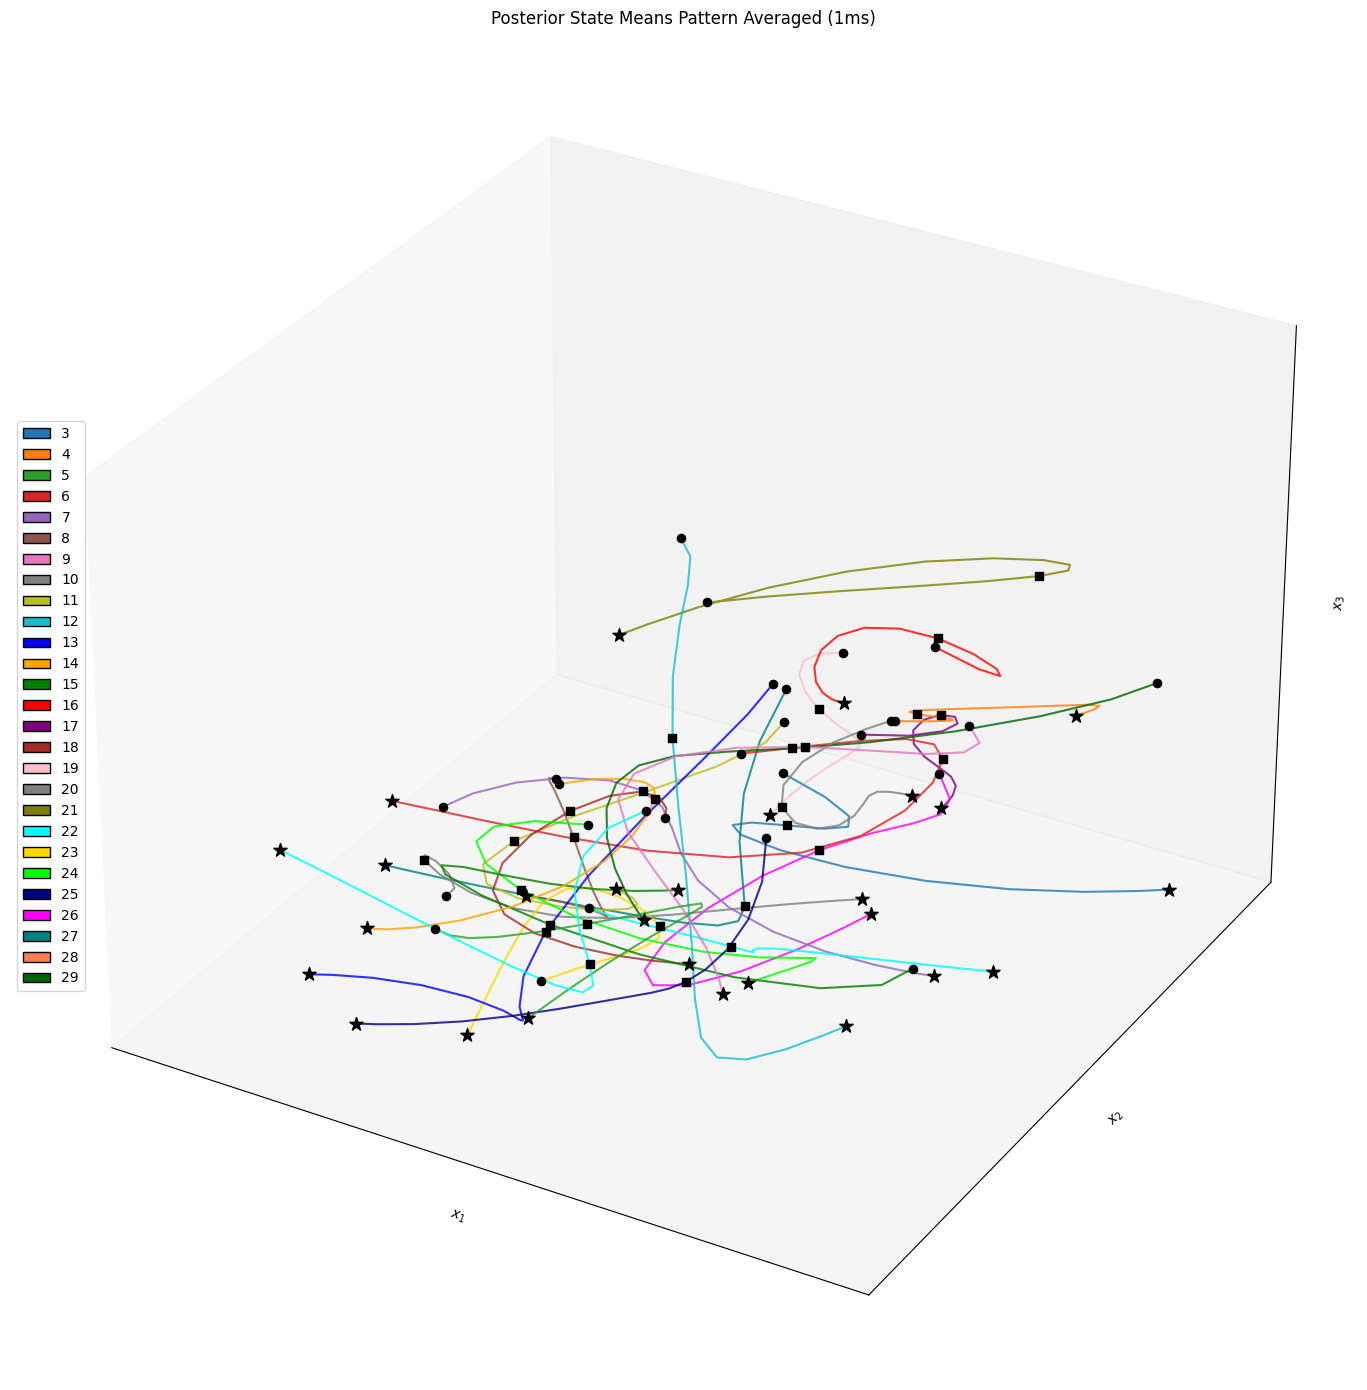

In [43]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

for i, j in enumerate(p_ids):
    # get trials where this pattern happens 
    idxs = np.where(data["pattern_id"][stim_idxs] == j)[0]

    d = [state_means[z] for z in idxs]

    d = np.array(d).mean(axis=0)

    p = gaussian_filter1d(d, 3, axis=0)

    ax.plot(p[5:, 0], p[5:, 1], p[5:, 2], c=colors[i], zorder=0, alpha=0.8)

    ax.scatter(p[5, 0], p[5, 1], p[5, 2], s=35, c="black", zorder=1, alpha=1)
    ax.scatter(p[10, 0], p[10, 1], p[10, 2], s=35, marker="s", c="black", zorder=1, alpha=1)
    ax.scatter(p[-1, 0], p[-1, 1], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)

ax.set_title(f"Posterior State Means Pattern Averaged ({bin_size}ms)")

ax.legend(handles=custom_patches, loc='center left')


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")


plt.tight_layout()

plt.savefig(f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/state_means_pattern_avg_{bin_size}ms_3D.png")

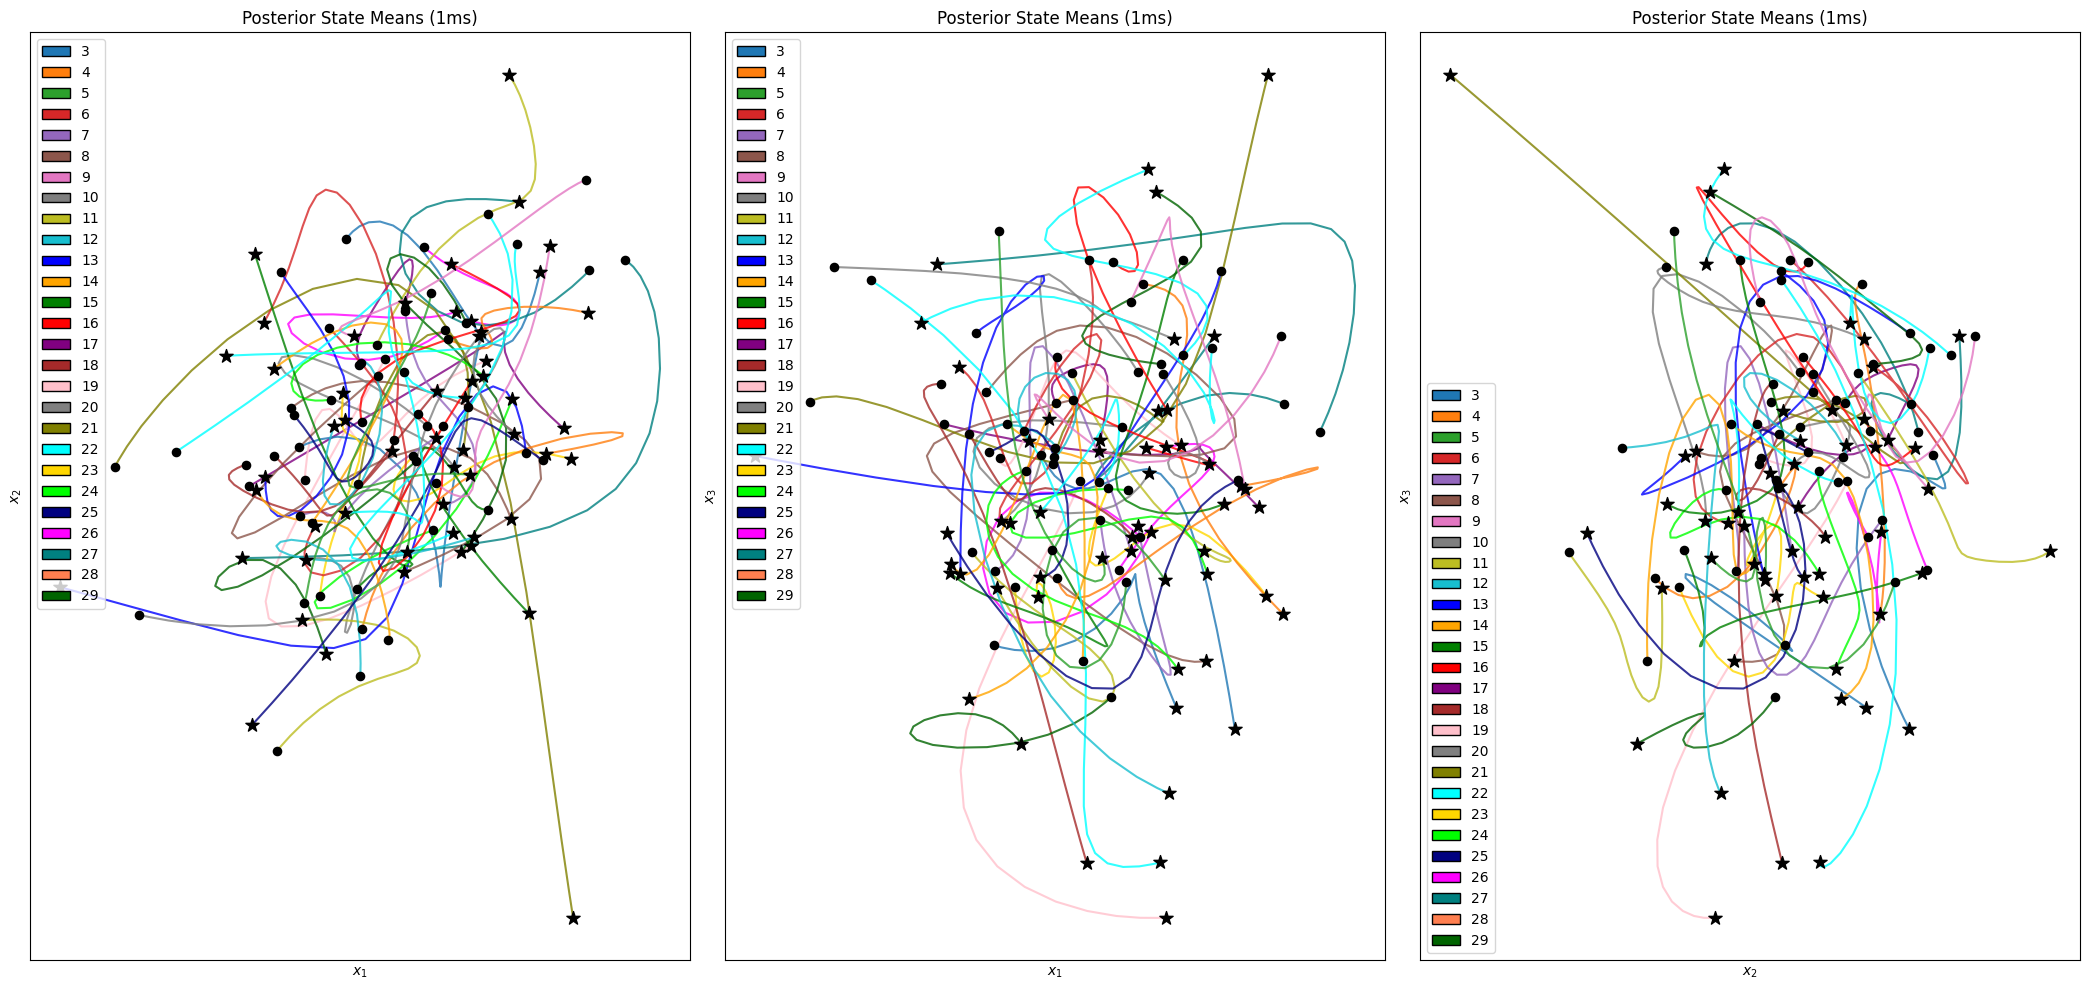

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, j in enumerate(p_ids):
    # get trials where this pattern happens 
    idxs = np.where(data["pattern_id"][stim_idxs] == j)[0][::5]

    for z in idxs:
        p = state_means[z]

        p = gaussian_filter1d(p, 4, axis=0)
    
        axes[0].plot(p[:, 0], p[:, 1], c=colors[i], zorder=0, alpha=0.8)
    
      #  axes[0].scatter(p[0, 0], p[0, 1], s=35, c="black", zorder=1, alpha=1)
        axes[0].scatter(p[0, 0], p[0, 1], s=35, marker='o', c="black", zorder=1, alpha=1)
        axes[0].scatter(p[-1, 0], p[-1, 1], s=100, marker='*', c="black", zorder=1, alpha=1)
    
        axes[1].plot(p[:, 0], p[:, 2], c=colors[i], zorder=0, alpha=0.8)
    
        axes[1].scatter(p[0, 0], p[0, 2], s=35, c="black", zorder=1, alpha=1)
    
        axes[1].scatter(p[-1, 0], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)
    
        axes[2].plot(p[:, 1], p[:, 2], c=colors[i], zorder=0, alpha=0.8)
    
        axes[2].scatter(p[0, 1], p[0, 2], s=35, c="black", zorder=1, alpha=1)
        axes[2].scatter(p[-1, 1], p[-1, 2], s=100, marker='*', c="black", zorder=1, alpha=1)



for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_3$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel("$x_2$")
axes[2].set_ylabel("$x_3$")

plt.tight_layout()

plt.savefig("/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/stim_window/subselect_trials.png")